# Computer Vison Final Assignment 2020

## Import Necessary Libraries

ROOT_DIR- Root directory of the project 

MODEL_DIR - Directory to save model and logs

COCO_MODEL_PATH - Path to Pre Trained Model


In [ ]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import cv2

# Root directory of the project
ROOT_DIR = os.path.abspath("../")
np.random.seed(0)
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "coco/"))  # To find local version
from samples.coco import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "val2017")

## Create Inference Model

In [ ]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()

## Load Pre-Trained Model

In [ ]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

In [ ]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

## Prepare and Load Dataset

In [ ]:
dataset = coco.CocoDataset() # Create Instance of COCO dataset to easily retrieve image and masks
dataset.load_coco(ROOT_DIR, "val",year='2017') # Specify type and year of the images downloaded
dataset.prepare()
class_names = dataset.class_names
print(dataset.class_names) # Print Class names of the objects

## Show random images output and mask with overlap and only mask

image_id  75 http://cocodataset.org/#explore?id=221291


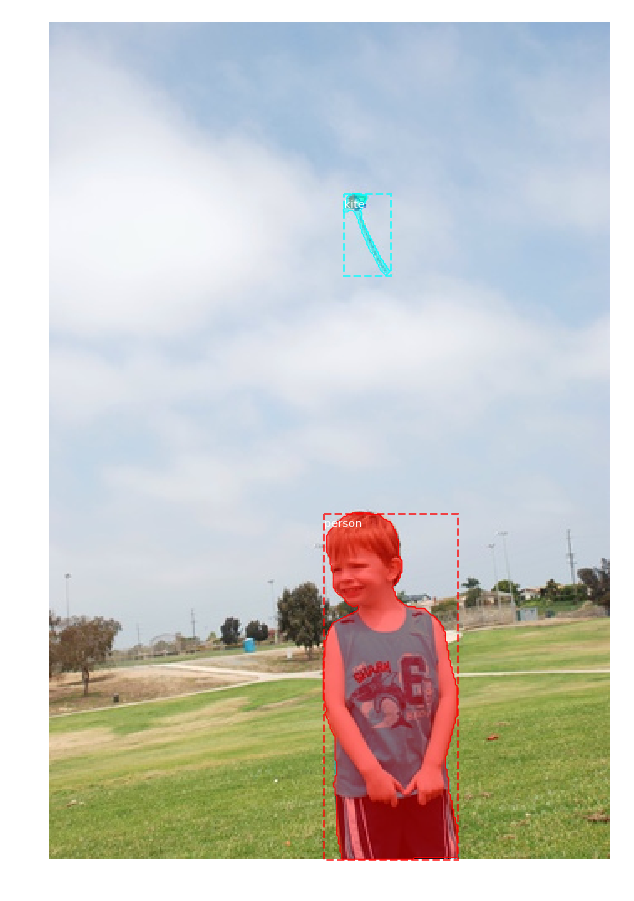

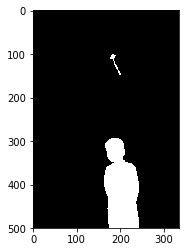

In [33]:
def ShowRandomImage():
    image_id = random.choice(dataset.image_ids)
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    # Compute Bounding box
    bbox = utils.extract_bboxes(mask)

    # Display image and additional stats
    print("image_id ", image_id, dataset.image_reference(image_id))
    # Display image and instances
    visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)
    ShowMask(image,mask)

def ShowMask(image,mask):
    obj = np.zeros((image.shape[0],image.shape[1]))
    for i in range(mask.shape[2]):
        obj += mask[:,:,i]
    plt.imshow(obj,cmap = 'gray')
    
ShowRandomImage()

## Image Enhancement Functions
Noise Adder

Contrast Changer

Histogram Equalization

CLAHE

UpMask Sharpening

Smoothing Filter(Different Types)

Laplace Filter

In [34]:
def AddNoise(img,mean,std):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    gray_img = img[:,:,2]
    noisy_img = gray_img + np.random.normal(mean, std, gray_img.shape)
    noisy_img_clipped = np.clip(noisy_img, 0, 255)
    img[:,:,2] = noisy_img_clipped
    img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
    return img

def ChangeContrast(img,contrast,brightness):
    img = cv2.addWeighted(img,contrast,np.zeros(img.shape,img.dtype),0,brightness)
    return img

def HistEq(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    gray_img = img[:,:,2]
    gray_img_eq = cv2.equalizeHist(gray_img)
    img[:,:,2] = gray_img_eq
    img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
    return img

def Smooth(img,mode):
    if(mode == 'avg'):
        return cv2.blur(img,(5,5))
    
    if(mode == 'gaus'):
        return cv2.GaussianBlur(img,(11,11),0)
        
    if(mode == 'med'):
        return cv2.medianBlur(img,5)
        
    if(mode == 'bilateral'):
        return cv2.bilateralFilter(img,9,75,75)

def Laplace(img):
    kernel = np.array([[-1,-1,-1],[-1,9,-1],[-1,-1,-1]])
#     print(kernel[0])
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    gray_img = img[:,:,2]
    img[:,:,2] = cv2.filter2D(gray_img,-1,kernel)
    img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
    return img

def unsharp_mask(image):
    kernel_size=(5, 5)
    sigma=1.0
    amount=1.0
    threshold=0
    blurred = cv2.GaussianBlur(image, kernel_size, sigma)
    sharpened = float(amount + 1) * image - float(amount) * blurred
    sharpened = np.maximum(sharpened, np.zeros(sharpened.shape))
    sharpened = np.minimum(sharpened, 255 * np.ones(sharpened.shape))
    sharpened = sharpened.round().astype(np.uint8)
    if threshold > 0:
        low_contrast_mask = np.absolute(image - blurred) < threshold
        np.copyto(sharpened, image, where=low_contrast_mask)
    return sharpened

def CLAHE(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    gray_img = img[:,:,2]
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(16,16))
    img[:,:,2] = clahe.apply(gray_img)
    img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
    return img

## Take 100 Random samples and modify them by adding noise and contrast

In [36]:
random.seed(0)
images = []
gt_class_ids = []
gt_bboxs = []
gt_masks = []
image_ids = random.sample(range(1, 200), 100)
for image_id in image_ids:
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
    image = AddNoise(image,0,5)
    contrast_up = random.uniform(0,1) > 0.5
    if(contrast_up):
        contrast = random.uniform(1,3)
    else:
        contrast = random.uniform(0.2,1)
    image = ChangeContrast(image,contrast,random.uniform(-100,100))
    images.append(image)
    gt_class_ids.append(gt_class_id)
    gt_bboxs.append(gt_bbox)
    gt_masks.append(gt_mask)

## Compute Map @ IoU = 50 score and show last images output

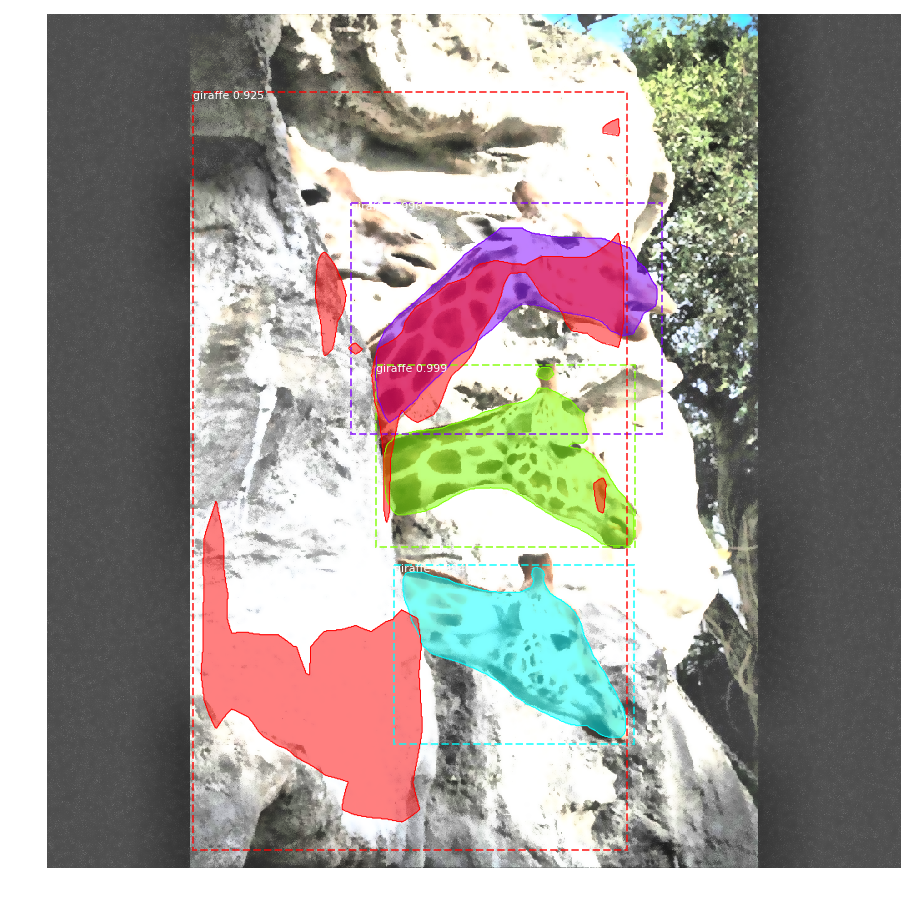

mAP @ IoU=50:  0.5163875277767981


In [37]:
def compute_batch_ap(image_ids):
    APs = []
    i = 0
    for image_id in image_ids:
        image = images[i]
        image = CLAHE(image)
        image = Smooth(image,'bilateral')
#         image = unsharp_mask(image)

        results = model.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        if(i == 99):
            visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                                class_names, r['scores'])
        AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bboxs[i], gt_class_ids[i], gt_masks[i],
                              r['rois'], r['class_ids'], r['scores'], r['masks'])
        APs.append(AP)
        i += 1
    return APs

APs = compute_batch_ap(image_ids)
print("mAP @ IoU=50: ", np.mean(APs))